# HARTH — Models & Evaluation (03_models.ipynb)

Confronto **Logistic Regression (L2) baseline** vs **LDA (shrinkage)** con validazione corretta **per soggetto**.

Ricetta (semplice e “da esame”):
1. Split finale **train/test** con `GroupShuffleSplit` (test = 20% soggetti).
2. Sul solo training: stima robusta con **GroupKFold (k=5)**.
3. Fit finale su tutto il training, valutazione una sola volta sul test.
4. Metriche: **macro-F1**, **balanced accuracy**, **confusion matrix**.

Prerequisito:
- aver eseguito `02_preprocessing.ipynb`, che salva:
  - `data/processed/X_features.parquet`
  - `data/processed/y_labels.parquet`
  - `data/processed/groups_subject.parquet`


In [7]:
!git clone https://github.com/Yanikko/progetto-AI-2.git
%cd progetto-AI-2

Cloning into 'progetto-AI-2'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 59 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 221.19 KiB | 6.70 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/progetto-AI-2


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 140)


## 1) Caricamento dataset preprocessato

File processati non trovati, eseguo preprocessing...


/usr/local/lib/python3.12/dist-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


CSV files: 22
Esempi: ['harth/S006.csv', 'harth/S008.csv', 'harth/S009.csv', 'harth/S010.csv', 'harth/S012.csv']
File: S006.csv subject: 6 shape: (408709, 8)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


Columns: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject,source_file
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6,6,harth/S006.csv
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6,6,harth/S006.csv
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6,6,harth/S006.csv
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6,6,harth/S006.csv
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6,6,harth/S006.csv


timestamp      datetime64[ns]
back_x                float64
back_y                float64
back_z                float64
thigh_x               float64
thigh_y               float64
thigh_z               float64
label                   int64
subject                 int64
source_file            object
dtype: object
Windows kept: 5033
Unique labels: 10


,count
7,3366
6,697
13,318
1,232
8,172
130,138
3,39
14,38
5,17
4,16


Feature rows: 79467
N subjects: 22
Class distribution (top):


,count
7,38550
1,14331
6,8084
8,5677
13,5091
2,3796
3,1277
4,818
14,667
5,614


X shape: (79467, 40) y: (79467,) groups: (79467,)


,back_0_mean,back_0_std,back_0_min,back_0_max,back_0_energy,back_1_mean,back_1_std,back_1_min,back_1_max,back_1_energy,back_2_mean,back_2_std,back_2_min,back_2_max,back_2_energy,thigh_0_mean,thigh_0_std,thigh_0_min,thigh_0_max,thigh_0_energy,thigh_1_mean,thigh_1_std,thigh_1_min,thigh_1_max,thigh_1_energy,thigh_2_mean,thigh_2_std,thigh_2_min,thigh_2_max,thigh_2_energy,back_mag_0_mean,back_mag_0_std,back_mag_0_min,back_mag_0_max,back_mag_0_energy,thigh_mag_0_mean,thigh_mag_0_std,thigh_mag_0_min,thigh_mag_0_max,thigh_mag_0_energy
0,-0.996587,0.038474,-1.272421,-0.952415,0.994665,0.071433,0.040270,-0.028849,0.467094,0.006724,0.066707,0.029406,-0.086133,0.141577,0.005315,-0.960233,0.045125,-1.300614,-0.870048,0.924083,0.073154,0.035164,0.030090,0.302179,0.006588,-0.303720,0.035148,-0.407529,-0.092001,0.093481,1.002417,0.043173,0.953865,1.362819,1.006704,1.011174,0.040989,0.965426,1.308329,1.024152
1,-0.983860,0.065738,-1.413744,-0.802925,0.972301,0.121802,0.103753,-0.192840,0.511083,0.025600,0.089364,0.046876,-0.085015,0.293643,0.010183,-0.993889,0.092250,-1.474092,-0.750604,0.996325,0.080636,0.126504,-0.303226,0.673558,0.022505,-0.221810,0.164835,-0.843538,0.553840,0.076370,1.001768,0.067417,0.858585,1.531699,1.008085,1.040724,0.109971,0.832054,1.500345,1.095201
2,-0.989083,0.006127,-1.003145,-0.980028,0.978323,0.101997,0.014883,0.064781,0.144725,0.010625,0.053265,0.007762,0.033504,0.081632,0.002897,-0.972996,0.004334,-0.989530,-0.955061,0.946740,0.019738,0.014870,-0.026735,0.056641,0.000611,-0.239936,0.012222,-0.275305,-0.207471,0.057719,0.995898,0.005653,0.985843,1.008072,0.991846,1.002521,0.004557,0.986028,1.016500,1.005070
3,-0.986296,0.004684,-1.003145,-0.980028,0.972802,0.109627,0.013354,0.078106,0.144725,0.012196,0.060995,0.009467,0.036793,0.081632,0.003810,-0.973578,0.003340,-0.989530,-0.957548,0.947866,0.013937,0.013086,-0.026735,0.056641,0.000365,-0.231581,0.009787,-0.258725,-0.207471,0.053726,0.994380,0.004229,0.986210,1.010653,0.988809,1.000971,0.003629,0.989470,1.016500,1.001957
4,-0.985436,0.003873,-1.001719,-0.980081,0.971100,0.116225,0.007092,0.101993,0.134631,0.013559,0.065270,0.006989,0.051615,0.086576,0.004309,-0.973808,0.002957,-0.989648,-0.960240,0.948310,0.012621,0.009145,-0.013471,0.027624,0.000243,-0.230910,0.007682,-0.255664,-0.209650,0.053379,0.994460,0.004010,0.988402,1.010903,0.988967,1.000960,0.003245,0.990293,1.018768,1.001932


Saved to: /content/progetto-AI-2/data/processed


,n_windows
subject,
6,5033
8,5088
9,1940
10,4123
12,4895
13,4375
14,4350
15,5133
16,4373


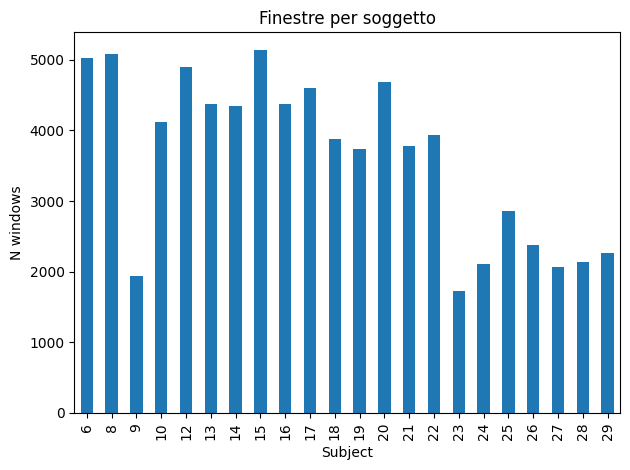

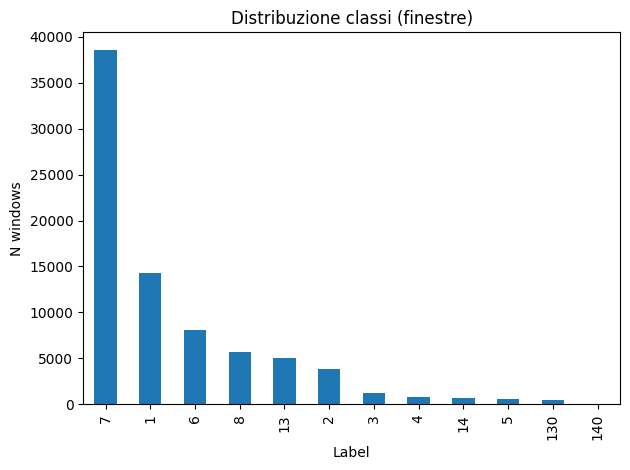

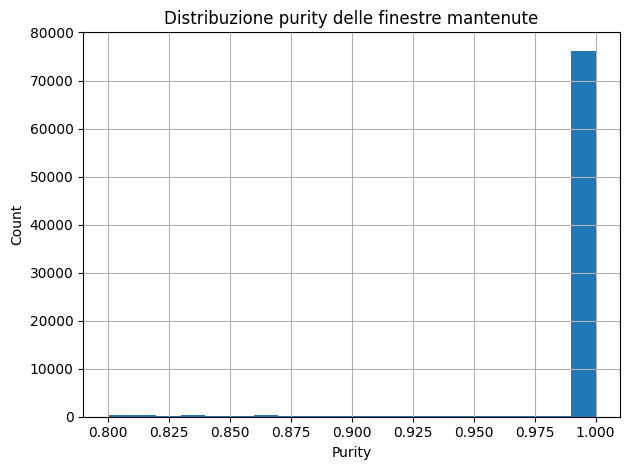

X: (79467, 40) y: (79467,) groups: (79467,)
N soggetti: 22 N classi: 12


,back_0_mean,back_0_std,back_0_min,back_0_max,back_0_energy,back_1_mean,back_1_std,back_1_min,back_1_max,back_1_energy,back_2_mean,back_2_std,back_2_min,back_2_max,back_2_energy,thigh_0_mean,thigh_0_std,thigh_0_min,thigh_0_max,thigh_0_energy,thigh_1_mean,thigh_1_std,thigh_1_min,thigh_1_max,thigh_1_energy,thigh_2_mean,thigh_2_std,thigh_2_min,thigh_2_max,thigh_2_energy,back_mag_0_mean,back_mag_0_std,back_mag_0_min,back_mag_0_max,back_mag_0_energy,thigh_mag_0_mean,thigh_mag_0_std,thigh_mag_0_min,thigh_mag_0_max,thigh_mag_0_energy
0,-0.996587,0.038474,-1.272421,-0.952415,0.994665,0.071433,0.040270,-0.028849,0.467094,0.006724,0.066707,0.029406,-0.086133,0.141577,0.005315,-0.960233,0.045125,-1.300614,-0.870048,0.924083,0.073154,0.035164,0.030090,0.302179,0.006588,-0.303720,0.035148,-0.407529,-0.092001,0.093481,1.002417,0.043173,0.953865,1.362819,1.006704,1.011174,0.040989,0.965426,1.308329,1.024152
1,-0.983860,0.065738,-1.413744,-0.802925,0.972301,0.121802,0.103753,-0.192840,0.511083,0.025600,0.089364,0.046876,-0.085015,0.293643,0.010183,-0.993889,0.092250,-1.474092,-0.750604,0.996325,0.080636,0.126504,-0.303226,0.673558,0.022505,-0.221810,0.164835,-0.843538,0.553840,0.076370,1.001768,0.067417,0.858585,1.531699,1.008085,1.040724,0.109971,0.832054,1.500345,1.095201
2,-0.989083,0.006127,-1.003145,-0.980028,0.978323,0.101997,0.014883,0.064781,0.144725,0.010625,0.053265,0.007762,0.033504,0.081632,0.002897,-0.972996,0.004334,-0.989530,-0.955061,0.946740,0.019738,0.014870,-0.026735,0.056641,0.000611,-0.239936,0.012222,-0.275305,-0.207471,0.057719,0.995898,0.005653,0.985843,1.008072,0.991846,1.002521,0.004557,0.986028,1.016500,1.005070
3,-0.986296,0.004684,-1.003145,-0.980028,0.972802,0.109627,0.013354,0.078106,0.144725,0.012196,0.060995,0.009467,0.036793,0.081632,0.003810,-0.973578,0.003340,-0.989530,-0.957548,0.947866,0.013937,0.013086,-0.026735,0.056641,0.000365,-0.231581,0.009787,-0.258725,-0.207471,0.053726,0.994380,0.004229,0.986210,1.010653,0.988809,1.000971,0.003629,0.989470,1.016500,1.001957
4,-0.985436,0.003873,-1.001719,-0.980081,0.971100,0.116225,0.007092,0.101993,0.134631,0.013559,0.065270,0.006989,0.051615,0.086576,0.004309,-0.973808,0.002957,-0.989648,-0.960240,0.948310,0.012621,0.009145,-0.013471,0.027624,0.000243,-0.230910,0.007682,-0.255664,-0.209650,0.053379,0.994460,0.004010,0.988402,1.010903,0.988967,1.000960,0.003245,0.990293,1.018768,1.001932


In [9]:
DATA_DIR = Path("data/processed")
X_path = DATA_DIR / "X_features.parquet"
y_path = DATA_DIR / "y_labels.parquet"
g_path = DATA_DIR / "groups_subject.parquet"

if not (X_path.exists() and y_path.exists() and g_path.exists()):
    print("File processati non trovati, eseguo preprocessing...")
    %run notebooks/02_preprocessing_HARTH.ipynb

X = pd.read_parquet(X_path)
y = pd.read_parquet(y_path).iloc[:, 0]      # colonna 'label'
groups = pd.read_parquet(g_path).iloc[:, 0] # colonna 'subject'

print("X:", X.shape, "y:", y.shape, "groups:", groups.shape)
print("N soggetti:", groups.nunique(), "N classi:", y.nunique())
display(X.head())


### Controlli rapidi: distribuzione classi e soggetti

,n_windows
label,
7,38550
1,14331
6,8084
8,5677
13,5091
2,3796
3,1277
4,818
14,667


,n_windows
subject,
6,5033
8,5088
9,1940
10,4123
12,4895
13,4375
14,4350
15,5133
16,4373


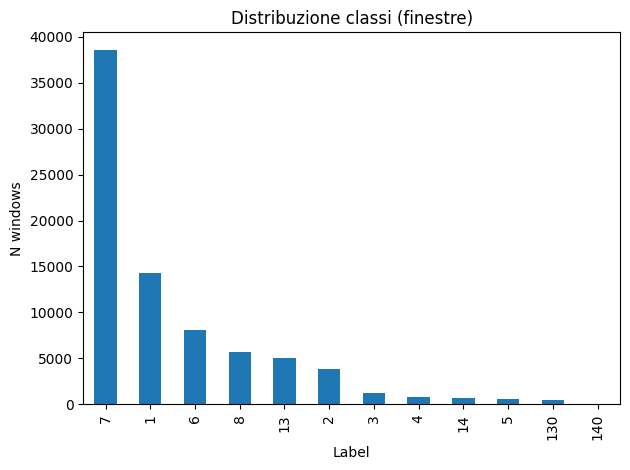

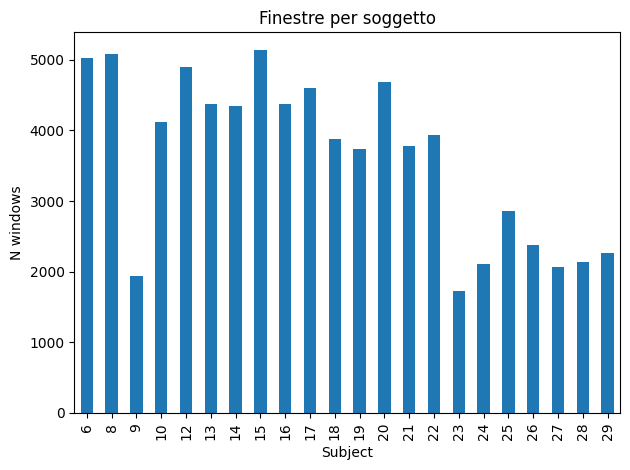

In [10]:
class_counts = y.value_counts()
subj_counts = groups.value_counts().sort_index()

display(class_counts.head(15).to_frame("n_windows"))
display(subj_counts.to_frame("n_windows").head(30))

plt.figure()
class_counts.head(20).plot(kind="bar")
plt.title("Distribuzione classi (finestre)")
plt.xlabel("Label")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()

plt.figure()
subj_counts.plot(kind="bar")
plt.title("Finestre per soggetto")
plt.xlabel("Subject")
plt.ylabel("N windows")
plt.tight_layout()
plt.show()


## 2) Split train/test per soggetto (GroupShuffleSplit)

In [11]:
from sklearn.model_selection import GroupShuffleSplit

RANDOM_STATE = 42
TEST_SIZE = 0.20  # ~4-5 soggetti su 22

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
g_train, g_test = groups.iloc[train_idx], groups.iloc[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train subjects:", sorted(g_train.unique()))
print("Test subjects:", sorted(g_test.unique()))
print("N train subjects:", g_train.nunique(), "N test subjects:", g_test.nunique())


Train: (59469, 40) Test: (19998, 40)
Train subjects: [np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(22), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
Test subjects: [np.int64(6), np.int64(8), np.int64(16), np.int64(21), np.int64(23)]
N train subjects: 17 N test subjects: 5


## 3) Modelli: LR-L2 baseline vs LDA (shrinkage)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Logistic Regression (baseline): L2 + class_weight per sbilanciamento
lr_l2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        multi_class="auto",
        class_weight="balanced",
        max_iter=2000
    ))
])

# LDA con shrinkage automatico: più robusto con feature correlate
lda_shrink = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage="auto"
    ))
])

models = {
    "LR (L2, class_weight=balanced)": lr_l2,
    "LDA (shrinkage=auto)": lda_shrink
}

list(models.keys())


['LR (L2, class_weight=balanced)', 'LDA (shrinkage=auto)']

## 4) Cross-validation sul training (GroupKFold)

In [13]:
from sklearn.model_selection import GroupKFold, cross_validate

cv = GroupKFold(n_splits=5)

scoring = {
    "macro_f1": "f1_macro",
    "balanced_acc": "balanced_accuracy"
}

cv_rows = []
for name, pipe in models.items():
    res = cross_validate(
        pipe,
        X_train, y_train,
        groups=g_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    cv_rows.append({
        "model": name,
        "cv_macro_f1_mean": float(np.mean(res["test_macro_f1"])),
        "cv_macro_f1_std": float(np.std(res["test_macro_f1"])),
        "cv_bal_acc_mean": float(np.mean(res["test_balanced_acc"])),
        "cv_bal_acc_std": float(np.std(res["test_balanced_acc"])),
    })

cv_df = pd.DataFrame(cv_rows).sort_values("cv_macro_f1_mean", ascending=False)
display(cv_df)


,model,cv_macro_f1_mean,cv_macro_f1_std,cv_bal_acc_mean,cv_bal_acc_std
0,"LR (L2, class_weight=balanced)",0.679916,0.046606,0.817759,0.068702
1,LDA (shrinkage=auto),0.650564,0.032790,0.735269,0.082776


## 5) Fit finale su train e valutazione sul test

In [14]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

test_rows = []
preds = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred

    test_rows.append({
        "model": name,
        "test_macro_f1": float(f1_score(y_test, y_pred, average="macro")),
        "test_balanced_acc": float(balanced_accuracy_score(y_test, y_pred)),
    })

test_df = pd.DataFrame(test_rows).sort_values("test_macro_f1", ascending=False)
display(test_df)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,model,test_macro_f1,test_balanced_acc
0,"LR (L2, class_weight=balanced)",0.646622,0.735544
1,LDA (shrinkage=auto),0.638133,0.699357


### Report dettagliato e confusion matrix

Best model on test (by macro-F1): LR (L2, class_weight=balanced)

Classification report:
              precision    recall  f1-score   support

           1      0.976     0.684     0.804      2353
           2      0.992     0.979     0.985       373
           3      0.391     0.801     0.525       332
           4      0.358     0.698     0.473        96
           5      0.154     0.808     0.259        78
           6      0.962     0.924     0.942      2517
           7      0.996     0.995     0.995     12185
           8      0.991     0.976     0.983      1278
          13      0.908     0.847     0.876       582
          14      0.365     0.426     0.393        54
         130      0.419     0.690     0.521       142
         140      0.000     0.000     0.000         8

    accuracy                          0.934     19998
   macro avg      0.626     0.736     0.647     19998
weighted avg      0.964     0.934     0.943     19998



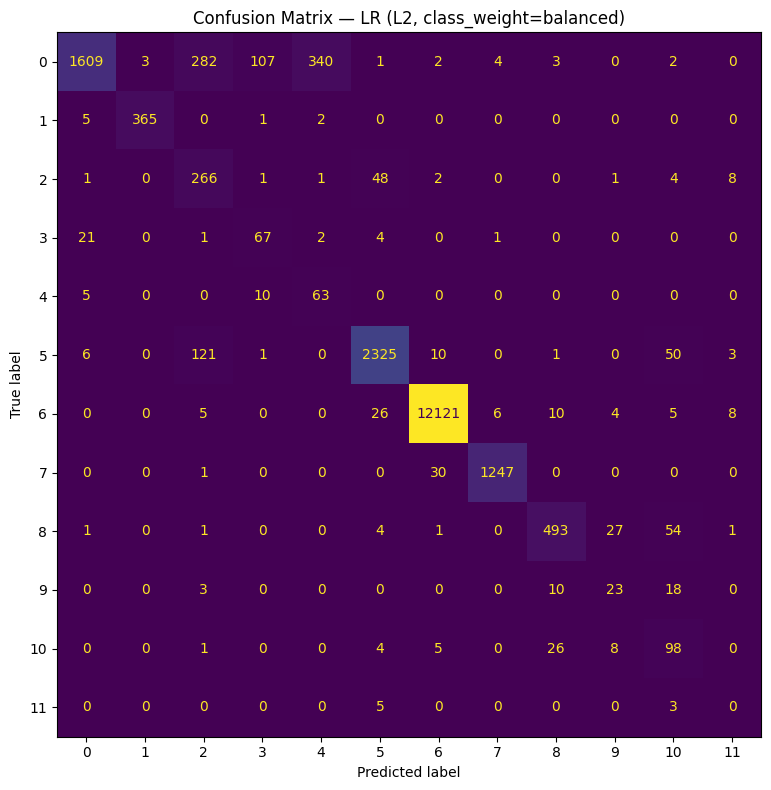

In [15]:
best_model_name = test_df.iloc[0]["model"]
print("Best model on test (by macro-F1):", best_model_name)

y_pred_best = preds[best_model_name]
print("\nClassification report:")
print(classification_report(y_test, y_pred_best, digits=3))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8, 8))
disp.plot(values_format="d", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
plt.show()


## 6) Note metodologiche (testo pronto per relazione)

- Lo split **per soggetto** evita leakage e misura la generalizzazione su persone non viste.
- Il test set viene usato **una sola volta** per il risultato finale.
- La GroupKFold sul training fornisce una stima più stabile (media ± deviazione standard).
- Metriche scelte (macro-F1, balanced accuracy) sono adatte a classi sbilanciate.
